## Delta Age Calculation

Here we use the script `04_epigenetic_age.R` to first download the corresponding age for our beta matrix, then we use it together with clinical data to compute delta age. 

In [1]:
import h5py

# adjust the path if needed
clin_file = h5py.File('../data/clinical_matched_final.h5', 'r')
print(list(clin_file.keys()))


['clinical']


In [2]:
# List all datasets/objects under the "clinical" group
print(list(clin_file['clinical'].keys()))


['axis0', 'axis1', 'block0_items', 'block0_values', 'block1_items', 'block1_values']


In [4]:
import pandas as pd

# Read the “clinical” table into a DataFrame
clin_df = pd.read_hdf('../data/clinical_matched_final.h5', key='clinical')

# Inspect the first few rows and column names
print(clin_df.shape)
print(clin_df.columns)
print(clin_df.head())


(693, 104)
Index(['project', 'submitter_id', 'synchronous_malignancy',
       'ajcc_pathologic_stage', 'days_to_diagnosis', 'laterality',
       'created_datetime', 'last_known_disease_status',
       'tissue_or_organ_of_origin', 'age_at_diagnosis',
       ...
       'treatments_radiation_treatment_dose',
       'treatments_radiation_number_of_fractions',
       'treatments_radiation_treatment_dose_units',
       'treatments_radiation_prescribed_dose_units',
       'treatments_radiation_route_of_administration',
       'treatments_radiation_prescribed_dose',
       'treatments_radiation_number_of_cycles', 'bcr_patient_barcode',
       'Subtype', 'Subtype_binary'],
      dtype='object', length=104)
     project  submitter_id synchronous_malignancy ajcc_pathologic_stage  \
0  TCGA-BRCA  TCGA-A7-A0DC                     No              Stage IA   
1  TCGA-BRCA  TCGA-Z7-A8R6                     No               Stage I   
2  TCGA-BRCA  TCGA-C8-A1HE                     No             Stage 

In [ ]:
import pandas as pd

# Load the three-clocks phenotype table
clocks_df = pd.read_csv('../results/epigenetic_age.csv')

# Inspect its columns and first few rows
print(clocks_df.columns)
print(clocks_df.head())


Index(['SampleID', 'Horvath', 'Hannum', 'PhenoAge'], dtype='object')
                       SampleID    Horvath     Hannum    PhenoAge
0  TCGA.C8.A27B.01A.11D.A16A.05  51.016160  59.922895   58.864954
1  TCGA.E9.A3Q9.01A.11D.A21R.05  90.682470  95.135643   77.420191
2  TCGA.C8.A3M8.01A.11D.A212.05  72.551975  81.478883  131.116288
3  TCGA.E9.A5FL.01A.11D.A27Y.05  52.947196  57.197608   51.469576
4  TCGA.A2.A25F.01A.11D.A16A.05  65.443928  76.206872   48.476791


In [ ]:
# Extract patient barcode from SampleID for merging
clocks_df['patient_id'] = (
    clocks_df['SampleID']
      .str.replace('.', '-', regex=False)
      .str.split('-')
      .str[:3]
      .str.join('-')
)

print(clocks_df[['SampleID', 'patient_id']].head())


                       SampleID    patient_id
0  TCGA.C8.A27B.01A.11D.A16A.05  TCGA-C8-A27B
1  TCGA.E9.A3Q9.01A.11D.A21R.05  TCGA-E9-A3Q9
2  TCGA.C8.A3M8.01A.11D.A212.05  TCGA-C8-A3M8
3  TCGA.E9.A5FL.01A.11D.A27Y.05  TCGA-E9-A5FL
4  TCGA.A2.A25F.01A.11D.A16A.05  TCGA-A2-A25F


In [7]:
# Merge clinical and clocks DataFrames on patient ID
merged_df = clin_df.merge(
    clocks_df,
    left_on='submitter_id',
    right_on='patient_id',
    how='inner'
)

# Check that the merge worked
print("Merged rows:", merged_df.shape[0])
print("Columns now include clock ages:", ['Horvath', 'Hannum', 'PhenoAge'])


Merged rows: 693
Columns now include clock ages: ['Horvath', 'Hannum', 'PhenoAge']


In [8]:
# Compute chronological age in years
merged_df['chrono_age'] = merged_df['age_at_diagnosis'] / 365.25

# Check the result
print(merged_df[['submitter_id', 'age_at_diagnosis', 'chrono_age']].head())


   submitter_id  age_at_diagnosis  chrono_age
0  TCGA-A7-A0DC           23294.0   63.775496
1  TCGA-Z7-A8R6           16955.0   46.420260
2  TCGA-C8-A1HE               NaN         NaN
3  TCGA-AC-A2FM           31805.0   87.077344
4  TCGA-B6-A1KF           24891.0   68.147844


In [26]:
# Calculate delta age for each clock
merged_df['delta_Horvath'] = merged_df['Horvath'] - merged_df['chrono_age']
merged_df['delta_Hannum']  = merged_df['Hannum']  - merged_df['chrono_age']
merged_df['delta_PhenoAge'] = merged_df['PhenoAge'] - merged_df['chrono_age']

# Preview the new delta columns
df = merged_df[['submitter_id',
                 'chrono_age',
                 'Horvath','delta_Horvath',
                 'Hannum','delta_Hannum',
                 'PhenoAge','delta_PhenoAge']]


In [27]:
df.head() 

,submitter_id,chrono_age,Horvath,delta_Horvath,Hannum,delta_Hannum,PhenoAge,delta_PhenoAge
0,TCGA-A7-A0DC,63.775496,56.251378,-7.524118,81.887942,18.112446,68.625691,4.850195
1,TCGA-Z7-A8R6,46.420260,60.334151,13.913891,41.935062,-4.485198,60.620185,14.199925
2,TCGA-C8-A1HE,NaN,118.668474,NaN,93.308850,NaN,123.740680,NaN
3,TCGA-AC-A2FM,87.077344,66.273647,-20.803697,88.594473,1.517129,78.990897,-8.086447
4,TCGA-B6-A1KF,68.147844,37.688618,-30.459226,52.308356,-15.839488,60.762564,-7.385280


In [28]:
df.to_csv('delta_age_with_chrono_age.csv', index=False)

In [11]:
# Select only the patient ID and delta-age columns
delta_df = merged_df[['submitter_id', 'delta_Horvath', 'delta_Hannum', 'delta_PhenoAge']]

# Save this delta-age-only table to its own CSV
delta_df.to_csv('delta_ages_only.csv', index=False)


In [13]:
delta_df.head()

,submitter_id,delta_Horvath,delta_Hannum,delta_PhenoAge
0,TCGA-A7-A0DC,-7.524118,18.112446,4.850195
1,TCGA-Z7-A8R6,13.913891,-4.485198,14.199925
2,TCGA-C8-A1HE,NaN,NaN,NaN
3,TCGA-AC-A2FM,-20.803697,1.517129,-8.086447
4,TCGA-B6-A1KF,-30.459226,-15.839488,-7.385280


       delta_Horvath  delta_Hannum  delta_PhenoAge
count     682.000000    682.000000      682.000000
mean        8.332736     14.262991       26.385602
std        21.494818     21.589990       31.344737
min       -63.731602    -47.875896      -49.538148
25%        -5.136051      0.255667        3.899130
50%         7.070214     13.287521       22.997552
75%        20.927791     26.513704       43.845220
max        97.365099    104.283385      198.296027
delta_Horvath: 0 samples >|100| years
delta_Hannum: 1 samples >|100| years
delta_PhenoAge: 17 samples >|100| years


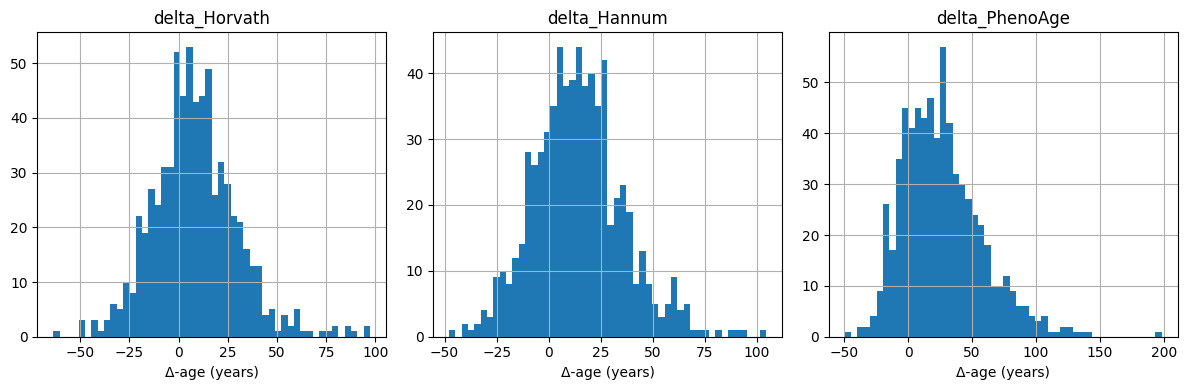

In [14]:
import pandas as pd
import matplotlib.pyplot as plt


d2 = delta_df.dropna(subset=["delta_Horvath","delta_Hannum","delta_PhenoAge"])

# 1) basic summary
print(d2[["delta_Horvath","delta_Hannum","delta_PhenoAge"]].describe())

# 2) how many extreme outliers > |100| years?
for col in ["delta_Horvath","delta_Hannum","delta_PhenoAge"]:
    n_out = (d2[col].abs() > 100).sum()
    print(f"{col}: {n_out} samples >|100| years")

# 3) histogram
fig, axes = plt.subplots(1,3,figsize=(12,4))
for ax, col in zip(axes, ["delta_Horvath","delta_Hannum","delta_PhenoAge"]):
    d2[col].hist(bins=50, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("Δ-age (years)")
plt.tight_layout()
plt.show()
